# Lab 7: Using a Pipeline for Text Transformation, Classification, and Optimization

In [1]:
import pandas as pd
import numpy as np
import os 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In this lab assignment, you will practice different techniques to use scikit-learn pipelines to automate the machine learning workflow. You will:

1. Load the Airbnb "listings" data set.
2. Combine two text columns to create one feature.
3. Use a scikit-learn pipeline to transform text data using a TF-IDF vectorizer and fit a logistic regression model to the transformed data. 
4. Evaluate the performance.
5. Add a grid search to the pipeline to find the optimal hyperparameter configuration.
6. Evaluate the performance of the optimal configuration using ROC-AUC.
7. Repeat the above steps using decision trees. 
8. Compare the performances of using a logistic regression model vs. a decision tree for this problem.

**<font color='red'>Note: some of the code cells in this notebook may take a while to run</font>**

## Part 1: Prepare the Data

We will work with a new version of the familiar Airbnb "listings" data set. It contains all of the numerical and binary columns we used previously, but also contains unstructured text fields.

### Load the Data Set

<b>Task</b>: In the code cell below, use the same method you have been using to load the data using `pd.read_csv()` and save it to DataFrame `df`.

You will be working with the file named "airbnb_text_readytofit.csv.gz" that is located in a folder named "data".

In [2]:
# YOUR CODE HERE
filename = os.path.join(os.getcwd(), "data", "airbnb_text_readytofit.csv.gz")
df = pd.read_csv(filename, header = 0)

In [54]:
df.head()

,name,description,neighborhood_overview,host_name,host_location,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_rate,...,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,has_availability_True,instant_bookable_True
0,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,False,True,True,-0.591438,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,False,True,True,-4.744653,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,Rebecca,"Brooklyn, New York, United States","Rebecca is an artist/designer, and Henoch is i...",False,True,True,0.578481,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,"New York, New York, United States",I used to work for a financial industry but no...,False,True,False,-0.060696,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,MaryEllen,"New York, New York, United States",Welcome to family life with my oldest two away...,False,True,True,0.578481,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [55]:
df.shape

(27388, 56)

### Reduce the Data Set

We will again build a classification model to predict whether or not the host is a superhost. The label will be `host_is_superhost`.

This time, the features will be `description` and `neighborhood_overview`. We will combine the values of both features into one feature.

<b>Task</b>: Create a new column in DataFrame `df` that contains concatenated values in the columns `description` and `neighborhood_overview`. The new column will be named `combined_text`.


In [3]:
# YOUR CODE HERE 
df['combined_text'] = df['description'] + df['neighborhood_overview']
df.head()

,name,description,neighborhood_overview,host_name,host_location,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_rate,...,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,has_availability_True,instant_bookable_True,combined_text
0,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,False,True,True,-0.591438,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"Beautiful, spacious skylit studio in the heart..."
1,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,False,True,True,-4.744653,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"Enjoy 500 s.f. top floor in 1899 brownstone, w..."
2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,Rebecca,"Brooklyn, New York, United States","Rebecca is an artist/designer, and Henoch is i...",False,True,True,0.578481,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN
3,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,"New York, New York, United States",I used to work for a financial industry but no...,False,True,False,-0.060696,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Please don’t expect the luxury here just a bas...
4,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,MaryEllen,"New York, New York, United States",Welcome to family life with my oldest two away...,False,True,True,0.578481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"Our best guests are seeking a safe, clean, spa..."


### Drop the Examples that Contain Missing Values

Let's removing missing values from our data.

<b>Task</b>: 

1. Drop all rows in DataFrame `df` in which the new column `combined_text` contains missing values.
2. Drop all rows in DataFrame `df` in which the column `host_is_superhost` contains missing values.


In [4]:
# YOUR CODE HERE
df.dropna(subset=['combined_text', "host_is_superhost"], inplace=True)


In [23]:
df.shape

(27388, 57)

## Part 2: Create Training and Test Data Sets

### Create Labeled Examples 

<b>Task</b>: Create labeled examples from DataFrame `df`. 
In the code cell below carry out the following steps:

* Get the `host_is_superhost` column from DataFrame `df` and assign it to the variable `y`. This will be our label.
* Get the `combined_text` column from  DataFrame `df` and assign it to the variable `X`. This will be our feature. 

In [7]:
# YOUR CODE HERE
y = df['host_is_superhost']
X = df['combined_text']

### Split Labeled Examples into Training and Test Sets

<b>Task</b>: In the code cell below create training and test sets out of the labeled examples. 

1. Use scikit-learn's `train_test_split()` function to create the data sets.

2. Specify:
    * A test set that is 20 percent of the size of the data set.
    * A seed value of '1234'. 
    

In [8]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1234)

## Part 3: Set up a TF-IDF + Logistic Regression Pipeline

### a. Set up and fit the pipeline with default parameters

In the code cell below you will create a pipeline that will perform TF-IDF vectorization and fits a logistic regression model to the transformed training data and makes predictions on the transformed test data.


<b>Task:</b> Follow the steps to complete the code in the cell below:

1. Define a list of steps. Name the list 's'. The list should contain two tuples:

    a.  Create a tuple that contains two items:
        * a name of your choosing to describe your vectorizer 
        * a TfidfVectorizer object - do not supply arguments when creating the object

    b. Create a tuple that contains two items:
        * a name of your choosing to describe your classifier
        * a LogisticRegression model object - supply the argument max_iter=300 when creating the object
    

2. Create a `Pipeline` object: assign the list `s` to the parameter `steps`. Name your pipeline `model_pipeline`.


3. Fit `model_pipeline` to the training data (`X_train` and `y_train`).


4. Call the `predict_proba()` method to use `model_pipeline` to make predictions on the test data (`X_test`). Save the second column to the variable `probability_predictions`. 

 
<b>Note</b>: this will take a number of minutes to run.

In [9]:
print('Begin ML pipeline...')

# 1. Define a list of steps. 

# YOUR CODE HERE
s = [("vectorizer", TfidfVectorizer()), ("model", LogisticRegression(max_iter = 300))]

# 2. Create a pipeline object

# YOUR CODE HERE
model_pipeline = Pipeline(steps = s)

# 3. Fit the pipeline to the training data

# YOUR CODE HERE
model_pipeline.fit(X_train, y_train)

# 4. Use the predict_proba() method to make predictions on the test data 

# YOUR CODE HERE
pred = model_pipeline.predict_proba(X_test)
probability_predictions = list(pred[:,1])

print('End pipeline')

Begin ML pipeline...
End pipeline


<b>Task</b>: Use the `roc_auc_score()` function to compute the AUC. Save the result to the variable `auc`.

In [10]:
# 5. Evaluate the performance by computing the AUC

# YOUR CODE HERE
auc = roc_auc_score(y_test, probability_predictions)

print('AUC on the test data: {:.4f}'.format(auc))

AUC on the test data: 0.7369


### b. Perform a grid search cv on the pipeline to find the best hyperparameters 

You will perform a grid search on the pipeline object to find the hyperparameter configuration for hyperparameter $C$ (for the logistic regression) and for the $ngram\_range$ (for the TF-IDF vectorizer) that result in the best cross-validation score.

<b>Task:</b> Define a parameter grid to pass to `GridSearchCV()`. Recall that the parameter grid is a dictionary. Name the dictionary `param_grid_LR`.

The dictionary should contain two key value pairs:

1. a key specifying the  $C$ hyperparamter name, and a value containing the list `[0.1, 1, 10]`.
2. a key specifying the $ngram\_range$ hyperparameter name, and a value containing the list `[(1,1), (1,2)]`.

When working with pipelines, the hyperparameter name is the name of the pipeline item (the descriptive name you provided to the item in the pipeline) followed by two underscores, followed by the actual hyperparameter name. For example, if you named your classifier `lrmodel`, the hyperparameter name for $C$ could be `lrmodel__C`. You can find a list containing possible pipeline hyperparameter names you can use by running the code the cell below.

In [61]:
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'model', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

In [11]:
# YOUR CODE HERE
param_grid_LR = {'model__C':[0.1, 1, 10], 'vectorizer__ngram_range':[(1,1), (1,2)]}

param_grid_LR

{'model__C': [0.1, 1, 10], 'vectorizer__ngram_range': [(1, 1), (1, 2)]}

<b>Task:</b> Run a grid search on the pipeline.

1. Call `GridSearchCV()` with the following arguments:

    1. Pipeline object `model_pipeline`.
    2. Parameter grid `param_grid_LR`.
    3. Specify 3 cross validation folds using the `cv` parameter.
    4. Specify that the scoring method is `roc_auc` using the `scoring` parameter.
    5. To monitor the progress of the grid search, supply the argument `verbose=2`.
    
    Assign the output to the object `grid_LR`.
    
    
2. Fit `grid_LR` on the training data (`X_train` and `y_train`) and assign the result to variable `grid_search_LR`.



In [13]:
print('Running Grid Search...')

# 1. Run a Grid Search with 3-fold cross-validation and assign the output to the object 'grid_LR'.

# YOUR CODE HERE
grid_LR = GridSearchCV(model_pipeline, param_grid_LR, cv = 3, scoring = 'roc_auc', verbose = 2)

# 2. Fit the model (grid_LR) on the training data and assign the fitted model to the 
#    variable 'grid_search_LR'

# YOUR CODE HERE
grid_search_LR = grid_LR.fit(X_train, y_train)

print('Done')

Running Grid Search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] model__C=0.1, vectorizer__ngram_range=(1, 1) ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 1), total=   6.0s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 1) ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 1), total=   5.8s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 1) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 1), total=   4.6s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 2) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 2), total=  13.9s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 2) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 2), total=  14.2s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 2) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 2), total=  15.9s
[CV] model__C=1, vectorizer__ngram_range=(1, 1) ......................
[CV] ....... model__C=1, vectorizer__ngram_range=(1, 1), total=  11.1s
[CV] model__C=1, vectorizer__ngram_range=(1, 1) ......................
[CV] ....... model__C=1, vectorizer__ngram_range=(1, 1), total=   7.2s
[CV] model__C=1, vectorizer__ngram_range=(1, 1) ......................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.0min finished


Done


Run the code below to see the best pipeline configuration that was determined by the grid search.

In [14]:
grid_search_LR.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

<b>Task</b>: Print the best hyperparameters by accessing them by using the `best_params_` attribute.

In [15]:
# YOUR CODE HERE
grid_search_LR.best_params_

{'model__C': 10, 'vectorizer__ngram_range': (1, 2)}

Recall that in the past, after we obtained the best hyperparameter values from a grid search, we re-trained a model with these values in order to evaluate the performance. This time we will do something different. Just as we can pass a Pipeline object directly to `plot_roc_curve()` to evaluate the model, we can pass `grid_search_LR.best_estimator_` to the function `plot_roc_curve()` to evaluate the model. We also pass in the test data (`X_test` and `y_test`). This allows the test data to be passed through the entire pipeline, using the best hyperparameter values.


<b>Task</b>: In the code cell below plot the ROC curve and compute the AUC by calling the function `plot_roc_curve()` with the arguments `grid_search_LR.best_estimator_` and the test data (`X_test` and  `y_test`). Note that you can simply just pass `grid_search_LR` to the function as well.

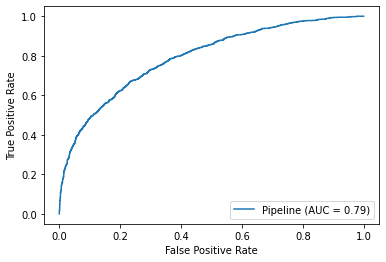

In [19]:
# YOUR CODE HERE
plot_roc_curve(grid_search_LR.best_estimator_, X_test, y_test)

## Part 4: Set up a TF-IDF + Decision Tree Pipeline

### a. Set up and fit the pipeline with default parameters

<b>Task:</b> Follow the steps to complete the code in the cell below:

1. Define a list of steps. Name the list 's'. The list should contain two tuples:

    a.  Create a tuple that contains two items:
        * a name of your choosing to describe your vectorizer 
        * a TfidfVectorizer object - supply the best value for ngram_range that was computed in the grid search

    b. Create a tuple that contains two items:
        * a name of your choosing to describe your classifier
        * a DecisionTreeClassifier model object - do not supply arguments when creating the object
    

2. Create a `Pipeline` object: assign the list `s` to the parameter `steps`. Name your pipeline `model_DT_pipeline`.


3. Fit `model_DT_pipeline` to the training data (`X_train` and `y_train`).


4. Call the `predict()` method to use `model_DT_pipeline` to make predictions on the test data (`X_test`). Save the result to a variable named `class_label_predictions`. 


In [16]:
print('Begin ML pipeline...')

# 1. Define a list of steps. 

# YOUR CODE HERE
s = [('vectorizer', TfidfVectorizer(ngram_range = (1, 2))), ('model_DT', DecisionTreeClassifier())]

# 2. Create a the pipeline object

# YOUR CODE HERE
model_DT_pipeline = Pipeline(steps = s)

# 3. Fit the pipeline to the training data

# YOUR CODE HERE
model_DT_pipeline.fit(X_train, y_train)

# 4. Use the predict() method to make predictions on the test data 

# YOUR CODE HERE
class_label_predictions = model_DT_pipeline.predict(X_test)

print('End pipeline')

Begin ML pipeline...
End pipeline


<b>Task</b>: Use `accuracy_score()` to compute the accuracy of the model. Save the result to the variable `acc_score`.

In [17]:
# 5. Evaluate the model by computing the accuracy score

# YOUR CODE HERE
acc_score = accuracy_score(y_test, class_label_predictions)
print('Accuracy score: {}'.format(acc_score))

Accuracy score: 0.6737451737451737


The `Pipeline` class has the built-in method `score()` that returns the accuracy score for classification models, and the R2 score for regression models.

Rather than implementing steps 4 and 5 above, we can use the method `score()` to obtain the accuracy of our model's predictions. Run the code cell below to try this approach. Notice that it returns the same accuracy score.

In [20]:
model_DT_pipeline.score(X_test, y_test)

0.6737451737451737

### b. Perform a grid search cv on the pipeline to find the best hyperparameters 

You will perform a grid search on the decision tree pipeline object to find the values for hyperparameters $max\_depth$ and $min\_samples\_split$ that result in the best cross-validation score for the decision tree.

<b>Task:</b> Define a parameter grid to pass to `GridSearchCV()`. Name the dictionary `param_grid_DT`.

The dictionary should contain two key value pairs:

1. a key specifying the $max\_depth$  hyperparameter name, and a value containing the list `[16, 32, 64]`.
2. a key specifying the $min\_samples\_split$  hyperparameter name, and a value containing the list `[50, 100]`.

First, in the code cell below, use the technique demonstrated above to find the hyperparameter names for your dictionary keys.

In [66]:
# YOUR CODE HERE
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'model', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

Next, create the parameter grid.

In [22]:
# YOUR CODE HERE
#fix dict keys 
param_grid_DT = {'model_DT__max_depth':[16, 32, 64], 'model_DT__min_samples_split':[50, 100]}
param_grid_DT

{'model_DT__max_depth': [16, 32, 64], 'model_DT__min_samples_split': [50, 100]}

<b>Task</b>: Run a Grid Search on `model_DT_pipeline`, with a 3-fold cross-validation. You will obtain the accuracy score, which is the default scoring method for `GridSearchCV`, so you do not have to specify the scoring method this time. As this will take a while to run, you can specify `verbose=2` to keep track of the progress.


Complete the code cell below.

In [23]:
print('Running Grid Search...')


# 1. Run a Grid Search with 3-fold cross-validation and assign the output to the object 'grid_DT'.

# YOUR CODE HERE
grid_DT = GridSearchCV(model_DT_pipeline, param_grid_DT, cv = 3, verbose = 2)

# 2. Fit the model (grid_DT) on the training data and assign the fitted model to the 
#    variable 'grid_search_DT'

# YOUR CODE HERE
grid_search_DT = grid_DT.fit(X_train, y_train)

print('Done')

Running Grid Search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] model_DT__max_depth=16, model_DT__min_samples_split=50 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model_DT__max_depth=16, model_DT__min_samples_split=50, total=  28.2s
[CV] model_DT__max_depth=16, model_DT__min_samples_split=50 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s remaining:    0.0s


[CV]  model_DT__max_depth=16, model_DT__min_samples_split=50, total=  28.6s
[CV] model_DT__max_depth=16, model_DT__min_samples_split=50 ..........
[CV]  model_DT__max_depth=16, model_DT__min_samples_split=50, total=  28.2s
[CV] model_DT__max_depth=16, model_DT__min_samples_split=100 .........
[CV]  model_DT__max_depth=16, model_DT__min_samples_split=100, total=  25.5s
[CV] model_DT__max_depth=16, model_DT__min_samples_split=100 .........
[CV]  model_DT__max_depth=16, model_DT__min_samples_split=100, total=  29.3s
[CV] model_DT__max_depth=16, model_DT__min_samples_split=100 .........
[CV]  model_DT__max_depth=16, model_DT__min_samples_split=100, total=  26.5s
[CV] model_DT__max_depth=32, model_DT__min_samples_split=50 ..........
[CV]  model_DT__max_depth=32, model_DT__min_samples_split=50, total=  40.1s
[CV] model_DT__max_depth=32, model_DT__min_samples_split=50 ..........
[CV]  model_DT__max_depth=32, model_DT__min_samples_split=50, total=  40.5s
[CV] model_DT__max_depth=32, model_DT__

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.6min finished


Done


Run the cell below to see the best pipeline configuration. Note that we now see the best values of the decision tree hyperparameters found above, and also see the ngram_range value we specified for the TF-IDF vectorizer. 

In [24]:
grid_search_DT.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model_DT',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=16,
            

<b>Task</b>: Print the best hyperparameters:

In [25]:
# YOUR CODE HERE
grid_search_DT.best_params_


{'model_DT__max_depth': 16, 'model_DT__min_samples_split': 50}

If you look at the scikit-learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for `GridSearchCV`, you will see that it implements a `score()` method based on the scoring method of the underlying Pipeline or model object.

The code cell below calls the `score()` method to make a prediction on the test data and output the accuracy score.

In [27]:
print(grid_DT.score(X_test, y_test))
print(grid_DT.score(X_train, y_train))
print(grid_search_LR.score(X_test, y_test))
print(grid_search_LR.score(X_train, y_train))

0.714561500275786
0.8009514616657474
0.7923558346415489
0.9999819427898259


<b>Analysis:</b> Which model performed better, and why do you think that is? How would you go about verifying your intuition?<br> Do you think it was appropriate to concatenate the values of the two text columns we used? Why or why not? What other way could you think of to use multiple text columns for a classification task? Record your findings in the cell below.

<Double click this Markdown cell to make it editable, and record your findings here.>
The logistic regression model performs better than the decision tree model even though they both overfit since the AUC scores on the training and test sets have a significant difference. The logistic regression model did better because it fit the data better since it fit almost perfectly on the training data. The parameter grid we chose to search for the best parameter was probably not the best. We should do a better job at the grid search stage by running a larger grid for both model for better model performances. I think it was appropriate to combine the two text columns since the two columns were very similar in that they described the airbnb. 